In [1]:


import sys
sys.path.append(r"D:\GITHUB_SOFTWARE\karyosight\karyosight\src")
from karyosight.stitcher import Stitcher
import karyosight.config as cfg

# 1. Import and instantiate
from karyosight.cropper import Cropper
from karyosight.visualization import plot_full_and_subgrid, plot_subgrid_layout
from pathlib import Path
# import config as cfg




d:\GITHUB_SOFTWARE\mamba_envs\karyosight-env\Lib\site-packages\dask\array\image.py:7: FutureWarning: `find_available_plugins` is deprecated since version 0.25 and will be removed in version 0.27. The plugin infrastructure of `skimage.io` is deprecated. Instead, use `imageio` or other I/O packages directly.
  from skimage.io import imread as sk_imread
d:\GITHUB_SOFTWARE\mamba_envs\karyosight-env\Lib\importlib\__init__.py:90: FutureWarning: `reset_plugins` is deprecated since version 0.25 and will be removed in version 0.27. The plugin infrastructure of `skimage.io` is deprecated. Instead, use `imageio` or other I/O packages directly.
  return _bootstrap._gcd_import(name[level:], package, level)
d:\GITHUB_SOFTWARE\mamba_envs\karyosight-env\Lib\site-packages\pydantic\_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


Stitcher

In [ ]:
# ────────────────────────────────────────────────────────────────────
# Toggle here: True = split into sub-grids; False = one full grid
USE_SUBGRID = True
# ────────────────────────────────────────────────────────────────────

import sys, os
sys.path.append(r"D:\GITHUB_SOFTWARE\karyosight\karyosight\src")

from karyosight.stitcher import Stitcher
import karyosight.config as cfg
import matplotlib.pyplot as plt
from multiview_stitcher import vis_utils
from karyosight.visualization import plot_subgrid_layout, plot_full_and_subgrid

# ────────────────────────────────────────────────────────────────────
# Your existing configuration
cfg.BATCH_GRID_SHAPE   = (6, 6)
cfg.BATCH_TILE_OVERLAP = 1
cfg.IMAGE_LOADER       = 'tif'
# ────────────────────────────────────────────────────────────────────

# Initialize stitcher and scale dict once
st    = Stitcher(cfg.RAW_DIR)
scale = {"x": cfg.PIXEL_SIZE_X, "y": cfg.PIXEL_SIZE_Y, "z": cfg.PIXEL_SIZE_Z}

for cond in st.conditions:
    print(f"\n=== {cond.name} ===")
    full_meta = st.extract_metadata(cond)
    groups    = st.group_tiles_by_prefix(full_meta)

    for prefix, tiles in groups.items():
        print(f"\n── Grid {prefix}: {len(tiles)} tiles ──")

        # Build gm either as multiple sub-grids or one full-grid
        if USE_SUBGRID:
            gm = st.build_dynamic_group_meta(full_meta, tiles, prefix, cond)
            ax = plot_subgrid_layout(st, gm, scale)
            ax.set_title(f"{prefix} sub-grids")
            plt.show()
        else:
            cols = full_meta["grid_size"]["cols"]
            rows = full_meta["grid_size"]["rows"]
            gm = {
                **full_meta,
                "subgrids": [
                    {
                        "id":      f"{prefix}_full",
                        "tiles":   tiles,
                        "x_range": (0, cols),
                        "y_range": (0, rows),
                    }
                ]
            }

        # Run the same stitching loop on gm["subgrids"]
        for sg in gm["subgrids"]:
            print(f" • {sg['id']} — {len(sg['tiles'])} tiles")

            # Optional visual debug for sub-grids
            if USE_SUBGRID:
                ax = plot_full_and_subgrid(st, full_meta, scale, sg)
                ax.set_title(sg["id"])
                plt.show()

            # Compute translations for this window (or full grid)
            trans = st.compute_translations({**gm, "tiles": sg["tiles"]}, scale)

            # Convert to Zarr & load the MSIMs
            zarr_paths, msims = st.convert_tiles_to_zarr(
                tiles=sg["tiles"],
                tif_folder=cond,
                scale=scale,
                translations=trans,
                tile_shape=gm["tile_shape"],
                subgrid_id=sg["id"],
                overwrite=True,
                use_gpu=True,
            )

            # Optional MV-Stitcher preview of positions
            fig, ax = vis_utils.plot_positions(
                msims,
                use_positional_colors=True,
                transform_key="affine_metadata",
            )
            ax.set_title(sg["id"])
            plt.show()

            # Optional channel alignment
            msims, key = st.perform_channel_alignment(msims, do_align=False)

            # Tile-to-tile registration
            params, fk = st.stitch_tiles(msims, key, scheduler="threads")

            # Fuse & export
            out_dir = cfg.STITCHED_DIR / cond.name / prefix / sg["id"]
            os.makedirs(out_dir, exist_ok=True)




            # Enable z-cropping for this session
            cfg.CROP_Z_BLACK_FRAMES = False
            cfg.Z_CROP_THRESHOLD = 0.005  # 1% of global max intensity

            print(f"Z-cropping enabled: {cfg.CROP_Z_BLACK_FRAMES}")
            print(f"Threshold: {cfg.Z_CROP_THRESHOLD} (empty slices below {cfg.Z_CROP_THRESHOLD*100}% of max intensity)")

            # Now when you call st.fuse_and_export(), add the parameters:
            st.fuse_and_export(
                msims, 
                out_dir, 
                export_tiff=False,
                crop_z_black_frames=cfg.CROP_Z_BLACK_FRAMES,
                z_crop_threshold=cfg.Z_CROP_THRESHOLD
            )
            # st.fuse_and_export(msims, out_dir, export_tiff=False) #old one
            print(f"→ Written to {out_dir}")


Cropper

In [2]:
# -----------------------------------------------------------------------------
# Production Cropping: Peak Mode + Black Frame Removal for All Zarrs
# -----------------------------------------------------------------------------
from pathlib import Path
from karyosight.cropper import Cropper
import karyosight.config as cfg
import numpy as np

# USER SETTINGS - OPTIMIZED FOR MAXIMUM PERFORMANCE
z_slices_around_peak = 16         # OPTIMIZED: 8 slices around peak = 17 total (was 16 = 33 total)
black_frame_threshold = 0.01     # 1% of max intensity threshold  
min_z_slices = 32                # OPTIMIZED: Reasonable minimum for 17 total slices (was 32)

print(f"🎯 OPTIMIZED Peak Mode: {z_slices_around_peak} slices around peak = {2*z_slices_around_peak + 1} total")
print(f"🧹 Black frame threshold: {black_frame_threshold} ({black_frame_threshold*100}% of max intensity)")
print(f"📏 Minimum slices: {min_z_slices}")

# NEW: Edge Detection Settings
print(f"✂️  Edge detection: {cfg.FILTER_EDGE_CROPPED} (filters out boundary-cropped organoids)")
if cfg.FILTER_EDGE_CROPPED:
    print(f"   • Edge proximity threshold: {cfg.EDGE_PROXIMITY_THRESHOLD*100}% of image size")
    print(f"   • Straight edge threshold: {cfg.STRAIGHT_EDGE_THRESHOLD*100}% of perimeter")
    print(f"   • Black region threshold: {cfg.BLACK_REGION_THRESHOLD*100}% of extended bbox")

pad_pct = 0.6
pad_step = 0.05

# instantiate your cropper  
cp = Cropper(  
    stitched_dir=Path(cfg.STITCHED_DIR),  
    cropped_dir=Path(cfg.CROPPED_DIR),  
    low_level=1,  
    high_level=0,  
    scheduler='threads',  
)

overview_root = Path(cfg.CROPPED_DIR)
stitched_root = Path(cfg.STITCHED_DIR)

# find all .zarr files under stitched/, but only keep the true "subgrid" ones
all_zarrs = [
    p for p in stitched_root.rglob("*.zarr")
    # parent folder name must equal the zarr filename (minus .zarr)
    if p.parent.name == p.stem
]

if not all_zarrs:
    print("⚠️  No subgrid zarrs found (parent.name != stem)!")
else:
    print(f"\n📂 Processing {len(all_zarrs)} zarr files...")
    
    for i, zarr_path in enumerate(sorted(all_zarrs)):
        # 1) grab the Condition_* parent
        cond_name = next(
            p.name
            for p in zarr_path.parents
            if p.name.startswith(cfg.CONDITION_PREF)
        )
        # 2) subgrid_id is simply the parent folder
        subgrid_id = zarr_path.parent.name

        print(f"\n[{i+1}/{len(all_zarrs)}] {cond_name} / {subgrid_id}")

        # extract ROIs with edge detection
        rois = cp.extract_rois_from_level(
            zarr_path,
            pad_pct=pad_pct,
            pad_step=pad_step,
            visualize=False,  # Skip visualization for speed
            verbose=False,     # Show edge detection results
            filter_edge_cropped=True  # Enable edge detection
        )
        
        print(f"   🔎 Found {len(rois)} ROIs")

        # Peak Mode + Aggressive Black Frame Removal
        try:
            # out_path = cp.bundle_and_save_rois(
            #     zarr_path, 
            #     rois,
            #     z_extraction_mode='peak',
            #     z_slices_around_peak=z_slices_around_peak,
            #     intensity_channel=0,              # Use CH1 for peak detection
            #     remove_black_frames=False,
            #     black_frame_threshold=black_frame_threshold,
            #     black_frame_method='intensity_threshold',
            #     min_z_slices=min_z_slices
            # )

            out_path = cp.bundle_and_save_rois_simple_optimized(
                zarr_path, rois,
                z_extraction_mode='peak',
                z_slices_around_peak=16,
                remove_black_frames=False,  # Fast
                progress_bar = True
                # chunk_size=5               # Resumable processing
            )            
            print(f"   ✅ Saved: {out_path.name}")
            
        except Exception as e:
            print(f"   ❌ Error processing {subgrid_id}: {e}")
            continue

print(f"\n🏁 Processing complete! All zarr files processed with peak mode + black frame removal.")
print(f"💡 Settings used: {2*z_slices_around_peak + 1} z-slices, {black_frame_threshold*100}% threshold")


🎯 OPTIMIZED Peak Mode: 16 slices around peak = 33 total
🧹 Black frame threshold: 0.01 (1.0% of max intensity)
📏 Minimum slices: 32
✂️  Edge detection: True (filters out boundary-cropped organoids)
   • Edge proximity threshold: 5.0% of image size
   • Straight edge threshold: 70.0% of perimeter
   • Black region threshold: 30.0% of extended bbox

📂 Processing 58 zarr files...

[1/58] Condition_D25T75 / LB_D25T75_large_1um___A01_G002_sg0_0


D:\GITHUB_SOFTWARE\karyosight\karyosight\src\karyosight\cropper.py:105: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  bw     = morphology.closing(bw, morphology.square(3))


   🔎 Found 14 ROIs


Processing Condition_D25T75: 100%|██████████| 14/14 [03:36<00:00, 15.47s/it]


   ✅ Saved: Condition_D25T75_bundled.zarr

[2/58] Condition_D25T75 / LB_D25T75_large_1um___A01_G002_sg0_1
   🔎 Found 10 ROIs


Processing Condition_D25T75: 100%|██████████| 10/10 [02:28<00:00, 14.88s/it]


   ✅ Saved: Condition_D25T75_bundled.zarr

[3/58] Condition_D25T75 / LB_D25T75_large_1um___A01_G002_sg0_2
   🔎 Found 3 ROIs


Processing Condition_D25T75: 100%|██████████| 3/3 [00:51<00:00, 17.25s/it]


   ✅ Saved: Condition_D25T75_bundled.zarr

[4/58] Condition_D25T75 / LB_D25T75_large_1um___A01_G002_sg1_0
   🔎 Found 13 ROIs


Processing Condition_D25T75: 100%|██████████| 13/13 [04:00<00:00, 18.51s/it]


   ✅ Saved: Condition_D25T75_bundled.zarr

[5/58] Condition_D25T75 / LB_D25T75_large_1um___A01_G002_sg1_1
   🔎 Found 12 ROIs


Processing Condition_D25T75:  33%|███▎      | 4/12 [01:25<02:51, 21.50s/it]


KeyboardInterrupt: 

Visualization

In [3]:
# Import the new visualization class
from karyosight.visualization import OrganoidVisualizer
import karyosight.config as cfg

# Initialize the visualizer
visualizer = OrganoidVisualizer(cropped_dir=cfg.CROPPED_DIR)

# 1. Count organoids per condition
print("=== Organoid Counts ===")
counts = visualizer.count_organoids_per_condition()
print("\nSummary:")
for condition, count in counts.items():
    print(f"  {condition}: {count} organoids")


=== Organoid Counts ===
Condition_D25T75: 45 organoids

Summary:
  Condition_D25T75: 45 organoids



=== Creating visualization for Condition_D50T50 ===
Saved visualization: D:\LUNGBUD_master\cropped\visualization\Condition_D50T50_CH1_level0_n20_individual.png


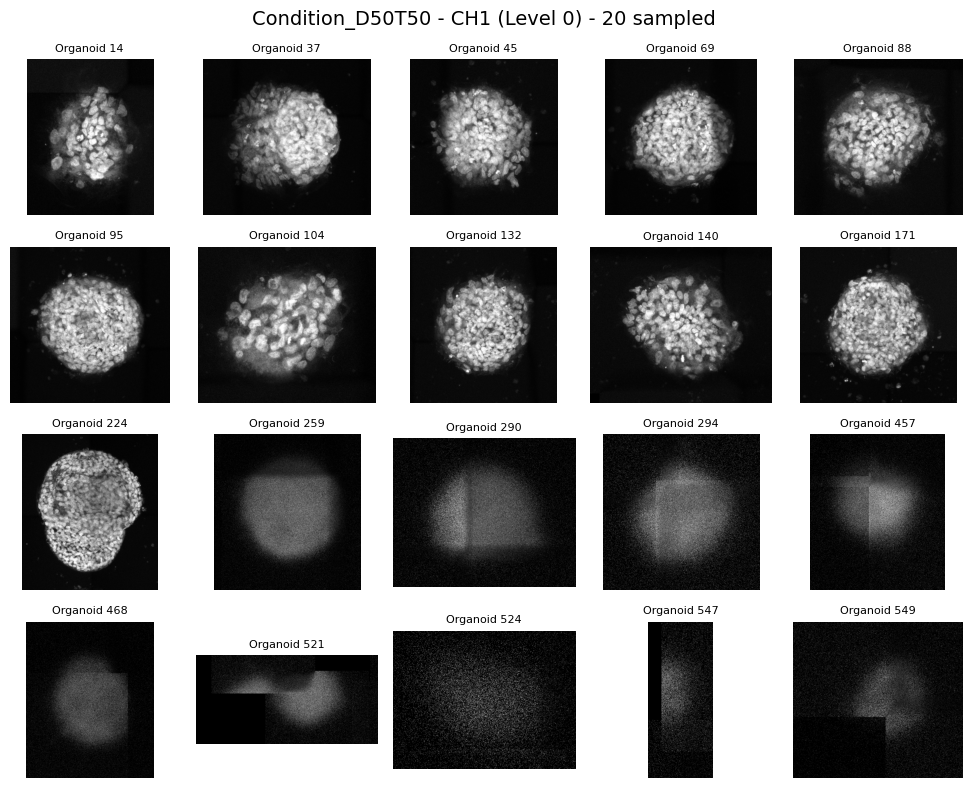

In [6]:
# 2. Create visualizations for a specific condition and channel
# Example: Visualize CH1 (channel 0) for first condition, sampling 12 organoids

if counts:
    # Get the first condition with organoids
    first_condition = next(cond for cond, count in counts.items() if count > 0)
    
    print(f"\n=== Creating visualization for {first_condition} ===")
    
    # Create grid visualization for CH1 (index 0)
    saved_path = visualizer.create_organoid_grid(
        condition=first_condition,
        channel=0,  # CH1
        level=0,   # Use pyramid level 1 (lower resolution)
        sample_count=20,  # Sample 12 organoids, or None for all
        auto_scale_method='individual',  # 'individual' or 'global'
        save_png=True,
        show_plot=True
    )



=== Testing FIXED Z-slice visualization ===
Testing with 3 z-slices (top, middle, bottom)
📊 Organoid volume shape: (33, 1058, 1112) (simple optimized format)
📊 Organoid 0 has 33 z-slices
📊 Organoid 0 has 33 z-slices
🎯 Showing z-slices: [0, 16, 32]
💾 Saved: D:\LB_TEST\cropped\Condition_D50T50\Condition_D50T50_organoid0_ch1_z3.png


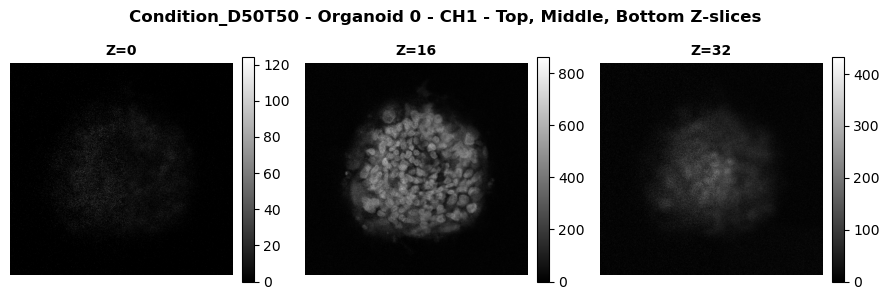

WindowsPath('D:/LB_TEST/cropped/Condition_D50T50/Condition_D50T50_organoid0_ch1_z3.png')

In [5]:
# 5. NEW: Test the FIXED Z-slice visualization function
print("\n=== Testing FIXED Z-slice visualization ===")

from karyosight.visualization import OrganoidVisualizer
import karyosight.config as cfg

visualizer = OrganoidVisualizer(cropped_dir=cfg.CROPPED_DIR)

# Test with just a few z-slices first to make sure dimensions are correct
print("Testing with 3 z-slices (top, middle, bottom)")
visualizer.view_organoid_z_slices(
    condition='Condition_D50T50',
    organoid_idx=0,
    channel=0,  # CH1
    level=0,  # Use level 0 (highest resolution) 
    z_slices=3,  # Just 3 slices to test
    save_png=True,
    show_plot=True
)





=== Creating channel comparison ===
💾 Saved: D:\LB_TEST\cropped\Condition_D50T50\Condition_D50T50_organoid0_channels.png


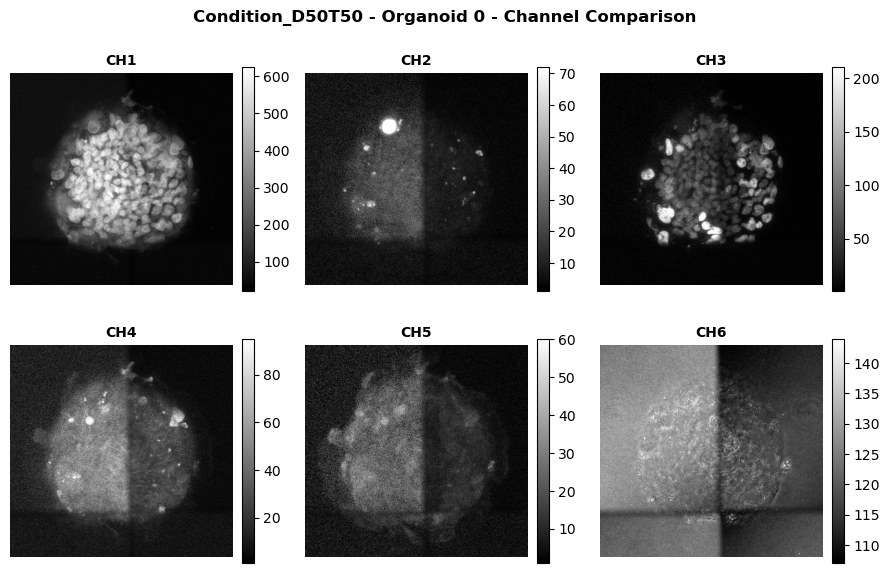

In [6]:
# 4. Create a channel comparison for a specific organoid
# This shows all 6 channels for a single organoid side-by-side

if counts:
    print("\n=== Creating channel comparison ===")
    
    # Compare all channels for organoid #0 in the first condition
    channel_comparison_path = visualizer.create_channel_comparison(
        condition=first_condition,
        organoid_idx=0,  # First organoid
        level=0,
        channels=None,  # None = all 6 channels, or specify [0,1,2] for specific channels
        auto_scale_method='individual',  # Scale each channel independently
        save_png=True,
        show_plot=True
    )
